> Este cuaderno es una copia de trabajo para resolver la tarea sin modificar el original.



## Tarea 4 Reinforcement Learning - TICS315 - Inteligencia Artificial

Integrantes del grupo:

* Integrante 1
* Integrante 2
* Integrante 3
* Integrante 4

## Reinforcement Learning

El aprendizaje por refuerzo (Reinforcement Learning) es una técnica dentro del campo del aprendizaje automático que se caracteriza por no proporcionar retroalimentación inmediata a los agentes. En lugar de ello, se permite que los agentes exploren y se desenvuelvan en su entorno, recibiendo recompensas por acciones correctas y penalizaciones por acciones incorrectas. 

A diferencia del aprendizaje supervisado, donde se proporciona retroalimentación para cada acción realizada, en el aprendizaje por refuerzo la evaluación de las acciones se realiza de manera diferida. Por ejemplo, en un videojuego, puede ser difícil determinar si un paso hacia adelante es positivo o negativo en el momento en que se realiza, ya que su impacto puede depender de eventos futuros. En este contexto, el aprendizaje por refuerzo se enfoca en reforzar las acciones que conducen a buenos resultados y penalizar aquellas que no lo hacen, sin preocuparse por las acciones intermedias cuyo impacto no es evidente de inmediato.

Este enfoque, también conocido como aprendizaje con retroalimentación diferida, permite a los agentes aprender estrategias óptimas a través de la interacción continua con su entorno.

## Ambiente para el agente

En esta sección se implementarán las partes necesarias para que el agente pueda interactuar con su entorno. Esto incluye la definición del mapa, los estados, las acciones disponibles y las condiciones que rigen el comportamiento del agente. Estas implementaciones permitirán modelar un entorno controlado donde el agente pueda aprender y tomar decisiones basadas en las recompensas obtenidas.

In [15]:
# copy para copiar nuestros objetos de un lado para otro
from copy import deepcopy, copy
# numpy es una libreria numerica que permite facil trabajo con
# matrices, como matlab. La usamos para trabajos numericos
import numpy as np
# para tener cosas random!
import random
# para ayudarnos con los tipos, nos ayuda a tener mas claro que retorna que
from typing import List, Tuple, Any, Union, NewType, Dict

# siempre es bueno usar una semilla cuando hacemos experimentos, es la unica
# forma confiable que tenemos para asegurarnos que nuestros experimentos
# son reproducibles
random.seed(42)  # no importa que numero elijamos, pero lo dejamos fijo
np.random.seed(42)


In [16]:
# Vamos a definir algunas cosas con `monitos` para que nuestro mapa se
# vea mas entretenido

# Partiremos con estos
ZOMBIE = "🧟"
HERO = "🙃"
TROPHIE = "🏆"
EMPTY = "⚪"

# despues ustedes tendran que agregar estos!
BLOCK = "🚫"
KEY = "🔑"
DOOR = "🚪"
SWORD = "🗡️"


# Nuestro agente tiene que saber las condiciones del mundo donde existe
# en este mundo solo hay 4 acciones que puede hacer.
# Moverse hacia `arriba`, `abajo`, `derecha` e `izquierda`, nada mas.
# En algun otro ambiente, podriamos agregar mas acciones como saltar
# atacar, comprar, etc. Pero mantendremos la simplicidad aqui.
UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3
# Juntamos nuestras acciones para que queden ordenadas.
ACTIONS = [UP, DOWN, LEFT, RIGHT]

In [17]:
# Aqui vamos a crear nuestros tipos, esto nos ayudara a entender que hace
# cada metodo y funcion que usemos mas claramente.
Action = NewType('Action', int)
GridElement = NewType('GridElement', str)

Arriba hemos definimos nuestro mapa. Esto no es importante para entender el concepto de *reinforcement learning*, sino mas bien es una pura implementación a mano de un mapa. Puedes saltarte toda la parte donde creamos la grilla.

In [18]:
# Aqui definimos nuestra grilla que acturará como la base de nuestro mapa
class Grid:
    # Nuestro constructor toma una lista u otra grilla y la guarda
    # se preocupa de copiarla para que no modifiquemos la anterior
    def __init__(self, grid:Union['Grid', List[List[GridElement]]]=None) -> None:
        assert grid is not None
        if isinstance(grid, list):
            self.grid = deepcopy(grid)
        elif isinstance(grid, Grid):
            self.grid = deepcopy(grid.grid)

        # Guardamos el tamaño de la grilla para trabajar mas rapido
        self.x_lim = len(self.grid[0])
        self.y_lim = len(self.grid)

    # Nuestro metodo para comparar una grilla con otra
    def __eq__(self, other:'Grid') -> bool:
        return isinstance(other, Grid) and self.grid == other.grid

    # Simpre es importante que si modificamos nuestra igualdad, tambien
    # adaptemos nuestro hash
    def __hash__(self) -> int:
        return hash(str(self.grid))

    # Cuando imprimimos una grilla, esta se mostrara como un
    # mapa, como una matriz
    def __str__(self) -> str:
        return '\n'.join([' '.join(str(e) for e in row) for row in self.grid])

    # Este es un metodo muy util para indexar partes de la grilla
    def __getitem__(self, position:Tuple[int, int]) -> GridElement:
        assert type(position) == tuple
        # necesitamos 2 coordenadas para saber que hay en esa posicion
        assert len(position) == 2
        x, y = position
        # verificamos que las coordenadas esten dentro de la grilla
        assert 0 < x <= self.x_lim
        assert 0 < y <= self.y_lim
        # retornamos el elemento que hay en esa posicion
        return self.grid[self.y_lim-y][x-1]

    # Este es un metodo muy util para insertar elementos en la grilla
    def __setitem__(self, position:Tuple[int, int], value:GridElement) -> None:
        assert type(position) == tuple
        assert len(position) == 2
        x, y = position
        assert 0 < x <= self.x_lim
        assert 0 < y <= self.y_lim
        # igual que antes, pero ahora asignamos un elemento en vez de retornarlo
        self.grid[self.y_lim-y][x-1] = value

    # Una forma `fancy` de acceder a variables de una clase sin un `getter`
    @property
    def shape(self) -> Tuple[int, int]:
        return (self.x_lim, self.y_lim)

Lo anterior pueden ignorarlo completamente, pero ahora si parte lo que nos importa!

A continuación definiremos una clase `State`, la cual representa el estado de nuestro agente en algun momento de su travesía.
Un estado tiene 3 cosas:


1.   El mapa en ese momento. Es decir, tenemos una grilla dentro del estado. Esto representará el estado del mapa en cada instante.
2.   Las posiciones de nuestro **heroe**, claramente necesitamos saber donde esta nuestro personaje en cada momento.
3.   Los limites del mapa, para no salirnos del mapa.


In [19]:
# La clase `State` representara un estado del heroe
class State:
    # En nuestro constructor solo asignamos nuestras variables
    def __init__(self, grid:Union[Grid, List[List[GridElement]]]=None,
                 hero_pos:Tuple[int,int]=(1,1),
                 collected_trophies:int=0,
                 required_trophies:int=None,
                 has_key:bool=False,
                 has_sword:bool=False) -> None:

        self.grid = Grid(grid=grid)
        self.x_lim, self.y_lim = self.grid.shape
        self.hero_x, self.hero_y = hero_pos
        self.has_key = has_key
        self.has_sword = has_sword
        self.collected_trophies = collected_trophies
        self.required_trophies = required_trophies
        if self.required_trophies is None:
            self.required_trophies = self._count_elements(TROPHIE)

    # Misma forma `fancy` de acceder a la posicion del heroe
    @property
    def hero_pos(self) -> Tuple[int, int]:
        return (self.hero_x, self.hero_y)

    @property
    def trophies_pending(self) -> int:
        return max(self.required_trophies - self.collected_trophies, 0)

    def _count_elements(self, element:GridElement) -> int:
        return sum(row.count(element) for row in self.grid.grid)

    # Para dibujar nuestro mapa con el heroe en la posicion actual
    def __str__(self) -> str:
        grid = deepcopy(self.grid)
        grid[self.hero_x, self.hero_y] = HERO
        inventory = []
        if self.has_key:
            inventory.append('🔑')
        if self.has_sword:
            inventory.append('🗡️')
        inv = ''.join(inventory) if inventory else 'vacío'
        status = (f"Tesoros: {self.collected_trophies}/{self.required_trophies} "
                  f"| Inventario: {inv}")
        return f"{grid.__str__()}\n{status}"

    # Un estado es igual a otro si las grillas y posiciones de los heroes son
    # las mismas
    def __eq__(self, other:'State') -> bool:
        return isinstance(other, State) and             self.hero_pos == other.hero_pos and             self.grid == other.grid and             self.collected_trophies == other.collected_trophies and             self.required_trophies == other.required_trophies and             self.has_key == other.has_key and             self.has_sword == other.has_sword

    # Igual que antes, por completitud debemos implementar cuando 2
    # estados tienen el mismo hash
    def __hash__(self) -> int:
        return hash((str(self.grid), self.hero_pos,
                    self.collected_trophies, self.required_trophies,
                    self.has_key, self.has_sword))

    # Este metodo nos ayuda a obtener que elemento se encuentra en una posicion
    # determinada. Necesitamos el estado pasado para comparar ya que no tenemos
    # historia, pero es una forma simple de implementar el mapa sin
    # mucho codigo. Recuerda que estamos en una cadena de Markov, aqui no tenemos
    # los estados pasados! Estos no afectan la decision que tomaremos ahora.
    def get_element(self, position:Tuple[int,int], state:'State') -> GridElement:
        assert type(position) == tuple
        assert len(position) == 2
        x, y = position
        assert 0 < x <= self.x_lim
        assert 0 < y <= self.y_lim

        # Por limitaciones de la implementacion, debemos saber si el heroe se
        # movio a la posicion en la que esta, o estaba ahi desde antes
        # otra implementacion podria solucionar este problema de mejor manera
        # pero es mas compleja de entender
        if position == state.hero_pos:
            return HERO
        return self.grid[x,y]

    # De nuestras acciones tenemos que elegir una y actuar acorde a ella.
    # por ejemplo, si le pedimos al estado que suba, entonces tenemos que
    # enviar la accion `UP`.
    # Cuando llamamos a este metodo, creamos un nuevo estado con la
    # accion aplicada
    def action_dispatch(self, action:Action) -> 'State':
        if action == UP:
            return self.moveUp()
        elif action == DOWN:
            return self.moveDown()
        elif action == LEFT:
            return self.moveLeft()
        elif action == RIGHT:
            return self.moveRight()
        else:
            raise ValueError(f"Unknown action {action}")

    # Este metodo solo copia el estado actual y crea uno nuevo para aplicar
    # los cambios pedidos por la accion ingresada
    def register(self) -> 'State':
        past_state = copy(self)
        return State(grid=past_state.grid,
                     hero_pos=past_state.hero_pos,
                     collected_trophies=past_state.collected_trophies,
                     required_trophies=past_state.required_trophies,
                     has_key=past_state.has_key,
                     has_sword=past_state.has_sword)

    # Los siguientes metodos mueven nuestro personaje en las direcciones
    # que definimos antes, arriba, abajo, derecha e izquierda

    def moveUp(self) -> 'State':
        new_state = self.register()
        new_state.hero_y = new_state.hero_y + 1 if new_state.hero_y < new_state.y_lim else new_state.hero_y

        return new_state

    def moveDown(self) -> 'State':
        new_state = self.register()
        new_state.hero_y = new_state.hero_y - 1 if new_state.hero_y > 1 else new_state.hero_y

        return new_state

    def moveRight(self) -> 'State':
        new_state = self.register()
        new_state.hero_x = new_state.hero_x + 1 if new_state.hero_x < new_state.x_lim else new_state.hero_x

        return new_state

    def moveLeft(self) -> 'State':
        new_state = self.register()
        new_state.hero_x = new_state.hero_x - 1 if new_state.hero_x > 1 else new_state.hero_x

        return new_state


Listo, con esto hemos definido las bases para que nuestro **agente** pueda moverse libremente por el mundo que creemos.
Probemos a ver como funciona!



In [20]:
# Creamos una lista de listas (una matriz) que represente a nuestro mapa
mapa_ejemplo = [
    [TROPHIE, EMPTY, EMPTY],
    [ZOMBIE, EMPTY, ZOMBIE],
    [EMPTY, EMPTY, EMPTY]
]
# Digamos que nuestro heroe parte en la posicion (1,1)
estado_ejemplo = State(grid=mapa_ejemplo, hero_pos=(1, 1))

# Veamos como se ve!
print(estado_ejemplo)

🏆 ⚪ ⚪
🧟 ⚪ 🧟
🙃 ⚪ ⚪
Tesoros: 0/1 | Inventario: vacío


En el mapa generado, el héroe 🙃 se encuentra representado en su posición inicial. Los trofeos 🏆, que representan los objetivos del agente, están distribuidos en el entorno, mientras que los zombies 🧟 actúan como obstáculos que el agente debe evitar. Los caminos libres están representados por círculos blancos ⚪, indicando las áreas transitables. Este entorno servirá como base para entrenar al agente utilizando el algoritmo de aprendizaje por refuerzo.

## Feedback para el **agente**

Hemos creado nuestro estado, nuestro mapa y todo, pero ahora necesitamos de alguna forma ver que acciones merecen un premio para el **agente** y cuales un castigo.

- [x] Mapa
- [x] Definición de un estado
- [ ] Cuándo dar recompensas y cuándo castigar
- [ ] Aprender...

Esto lo definiremos en una función que llamaremos `act`. La función `act` necesita un `State` `s` y un `Action` `a` como argumentos, para simular un movimiento, desde un estado `s` mediante la acción `a`.

## Listos para aprender!

Ahora tenemos todo nuestro ambiente implementado y definido.

- [x] Mapa
- [x] Definición de un estado
- [x] Cuándo dar recompensas y cuando castigar
- [ ] Aprender...

Lo que necesitamos ahora es algun algoritmo que nos ayude a aprender que acciones son buenas y cuales no. Para esto usaremos un algoritmo llamado *Q-Learning*, que es lo que vimos en la clase teórica antes.

Para esto, primero necesitamos una tabla donde iremos guardando cada uno de los estados y sus puntajes para cada acción. Es decir, dado un estado `s`, que deberíamos hacer ahora. Esta decisión se toma de acuerdo a un puntaje que va asociado a cada acción dado cada estado.

In [21]:
# Declaramos nuestra tabla `q_table` como un diccionario vacio
# Nuestra tabla se vera de la siguiente forma:
# estado: [lista de acciones posibles]
# Esta lista de acciones posibles es una lista de puntajes para cada
# accion dado un estado.
q_table = {}

# Luego hacemos nuestra funcion de busqueda `q`.
# Esta tiene 2 funciones:
# 1. Dado  un estado, retorna una lista con los puntajes para cada accion en ese
# estado. Es decir, una lista con puntajes para decidir que hacer
# 2. Dado un estado y una accion, retorna el puntaje asociado a realizar
# esa accion en ese estado.
def q(state:State, action:Action=None) -> Union[float, np.ndarray]:
    if state not in q_table:
        # Si no hemos visto este estado, lo creamos
        # como no sabemos que hacer aun, decimos que todas las acciones
        # tienen beneficio 0, ya que no lo hemos evaluado aun
        q_table[state] = np.zeros(len(ACTIONS))

    if action is None:
        return q_table[state]

    return q_table[state][action]

# Este es un metodo conveniente para no estar borrando manualmente
# la tabla cada vez que queremos hacer algo nuevo
def reset_table():
    global q_table
    q_table = {}


In [22]:
# Definimos una funcion que represente un `acto`. Es decir
# dado un estado y una accion, que ocurre.
# Este "que ocurre" es bastante variado, podemos movernos,
# ganar puntaje, perder el juego, o cualquier cosa que decidamos

# Aqui es donde debemos decidir cuando y cuanta recompensa o castigo
# debemos dar a nuestro agente.
# Esta funcion retornara 3 cosas. El nuevo estado en que quedo nuestro heroe,
# una recompensa por su esfuerzo (puede ser negativa), y un booleano indicando
# si el juego termino o no. Este `termino` puede ser porque ganamos o perdimos.
def act(state:State, action:Action):

    # Le decimos a nuestro estado que se mueva en la direccion pedida
    # esto nos da un nuevo estado
    new_state = state.action_dispatch(action)

    # ahora le pedimos al nuevo estado que nos diga que hay
    # en la posicion que quedamos
    # De nuevo, por un tema de implementacion tenemos que saber si donde estamos
    # ahora estaba ocupado por otro elemento, o si siempre estuvimos nosotros ahi.
    grid_item = new_state.get_element(new_state.hero_pos, state)

    # Recompensas por defecto
    reward = -1
    is_done = False

    if grid_item == ZOMBIE:

        if new_state.has_sword:
            # Podemos derrotarlo y seguir avanzando
            new_state.grid[new_state.hero_pos] = EMPTY
            reward = 200
            is_done = False
        else:
            reward = -100
            is_done = True

    elif grid_item == TROPHIE:
        new_state.grid[new_state.hero_pos] = EMPTY
        new_state.collected_trophies += 1
        if new_state.collected_trophies >= new_state.required_trophies:
            reward = 1000
            is_done = True
        else:
            reward = 250
            is_done = False

    elif grid_item == EMPTY:
        reward = -1
        is_done = False

    elif grid_item == HERO:
        reward = -1
        is_done = False

    elif grid_item == BLOCK:
        reward = -15
        return state, reward, False

    elif grid_item == DOOR:
        if new_state.has_key:
            new_state.grid[new_state.hero_pos] = EMPTY
            reward = -1
            is_done = False
        else:
            reward = -25
            return state, reward, False

    elif grid_item == KEY:
        new_state.has_key = True
        new_state.grid[new_state.hero_pos] = EMPTY
        reward = 75
        is_done = False

    elif grid_item == SWORD:
        new_state.has_sword = True
        new_state.grid[new_state.hero_pos] = EMPTY
        reward = 75
        is_done = False

    else:
        raise ValueError(f"Unknown grid item {grid_item}")

    return new_state, reward, is_done


Para terminar nuestras configuraciones, es necesario que digamos cuantas veces intentaremos correr el juego, y tambien la duración del juego. Por ejemplo, podríamos estar jugando 1 hora por 2 semanas, o 14 horas en un puro dia. Para asimilar lo aprendido, primero debemos dormir, es decir, dejar de jugar.

Este ejemplo de dormir y tiempo entre juegos es una analogia muy util para describir el concepto de `episodios` y `pasos` de nuestro **agente**. Por cada `episodio` nuestro agente comienza el juego denuevo y podemos darnos cuenta si mejoró o no, entonces no nos sirve solo hacer un `episodio` super largo si no tendremos la oportunidad de verificar los resultados; pero si tenemos demasiados episodios, no terminaremos de jugar nunca. El "largo" del juego viene dado por los `pasos`. Si son muy pocos `pasos` puede que no alcancemos a aprender lo que queremos, pero si son muchos puede que estemos perdiendo el tiempo y ya hayamos encontrado lo que buscabamos.

A continuacion definiremos estas constantes para nuestro problema.

In [23]:
# El total de episodios donde nuestro agente aprendera
N_EPISODES = 400

# El maximo numero de pasos por episodio
MAX_EPISODE_STEPS = 200

# Debemos definir nuestro conjunto de pesos de entrenamiento.
# En un comienzo nuestro agente aprendera mucho, ya que sus primeros
# acercamientos al juego son mas valiosos. Pero mientras mas veces jugamos
# lo que aprendemos por cada jugada es cada vez menos. Es importante hacer esta
# diferencia o una jugada muy avanzada, por intentar explorar, podria
# arruinar todo lo que habiamos aprendido antes.

# Siempre aprenderemos aun que sea un poco
MIN_ALPHA = 0.05
# Aprenderemos desde TODO, hasta un 5% de lo que veamos.
alphas = np.linspace(1.0, MIN_ALPHA, N_EPISODES)

# Un factor de descuento. Esto lo usamos para balancear entre la recompensa
# maxima a corto plazo, o a largo plazo. Si lo dejamos solo a corto plazo
# es poco probable que aprendamos algo util a futuro. Pero si lo dejamos en
# 100% entonces estamos pensando demasiado en el futuro y no nos estamos
# preocupando del presente.
gamma = 0.95

# Valores de epsilon para cada episodio, asi balanceamos exploracion
EPSILON_START = 0.4
EPSILON_END = 0.05
epsilons = np.linspace(EPSILON_START, EPSILON_END, N_EPISODES)

# Aqui simulamos la eleccion de una accion. Dado un estado, nos dice que
# accion tomar. Existe un epsilon de probabilidad de que tomemos una accion
# al azar.
def choose_action(state:State, epsilon:float) -> Action:
    if random.random() < epsilon:
        return random.choice(ACTIONS)
    else:
        return np.argmax(q(state))


Listo! Implementemos `Q-learning` para que nuestro heroe 🙃 aprenda como obtener los trofeos 🏆!

Según lo visto en clases la siguiente ecuación se basa en las *cadenas de Markov*. La formula para aprender mediante `Q-learning` viene dada por la siguiente expresin:

$$ Q^{nuevo}(s_t, a_t) =
    \underbrace{Q(s_t, a_t)}_{\text{valor antiguo}} +
    \underbrace{\alpha}_{\text{la tasa de aprendizaje}} *
        \overbrace{
            \left(\underbrace{r_t}_{\text{recompensa}} +
            \underbrace{\gamma}_{\text{factor descuento}} *
                \underbrace{\max_{acciones}(Q(s_{t+1},acciones))}_{\text{valor optimo futuro}} -
                \underbrace{Q(s_t, a_t)}_{\text{diferencia temporal}}
            \right)}
        ^{\text{lo que aprendimos}}
$$

Básicamente, para el estado actual, debemos ajustar el valor que nos dice que accion tomar basandonos en cual creemos que es el estado que nos da una mayor recompensa en el futuro. Es decir, desde el estado donde estamos, que acción nos lleva a un estado de mayor recompensa. El término $Q(s_t, a_t)$ es importante porque representa la diferencia temporal del estado actual con el siguiente. No hay garantía que visitar 2 veces el mismo estado nos de la misma recompensa, por lo que hay que considerar que existe el tiempo en nuestra ecuacion.

En el siguiente trozo de código implementamos esta ecuación en un loop `for`. Para cada número de `episodios`, avanzamos/ejecutamos hasta que el juego termina (porque ganamos o perdimos) o hasta que alcancemos el máximo de `pasos`. Es importante señalar que no todos los juegos *terminan*, asi que es importante que tengamos un límite hasta cuando queremos seguir. También, si nos quedamos parados en el mismo lugar sin movernos, y no hay condiciones de tiempo, el juego durará para siempre. Hay que arreglar esos detalles.

In [24]:
def q_learning(start_state:State, episodes:int, steps:int,
               table:Dict[State, np.ndarray], learning_rate:np.ndarray,
               discount:float, exploration_schedule:np.ndarray) -> List[float]:

    episode_rewards = []

    for ep in range(episodes):

        # Creamos una copia para no modificar nuestro estado original
        state = deepcopy(start_state)

        # Partimos con una recompensa 0
        total_reward = 0

        # Cada episodio tiene una tasa de aprendizaje distinto
        alpha = learning_rate[ep]
        epsilon = exploration_schedule[ep]

        # Para cada paso, vamos a ir actualizando nuestra tabla
        # para encontrar los movimientos que nos llevaran a ganar el juego
        for _ in range(steps):

            # Tomamos una accion de nuestro banco de acciones
            # dado nuestro estado
            action = choose_action(state, epsilon)

            # Llamamos un `acto`, para ver si lo hicimos bien
            # necesitamos indicarle el estado donde estamos y la accion a
            # realizar
            # Esto nos da un nuevo estado, una recompensa y nos dice
            # si se termino el juego o no.
            next_state, reward, done = act(state, action)

            # Vamos guardando nuestras recompensas
            total_reward += reward

            # Actualizamos nuestros estados con la formula que vimos antes
            q(state)[action] = q(state, action) +                 alpha * (reward + discount * np.max(q(next_state)) - q(state, action))

            # estamos listos para el siguiente paso
            state = next_state

            # si el juego termino, dejamos los pasos y comenzamos con un
            # nuevo episodio
            if done:
                break

        episode_rewards.append(total_reward)
        print(f"Episode {ep + 1}: total reward -> {total_reward}")

    return episode_rewards


## Resultados del entrenamiento

El entrenamiento del agente se llevó a cabo utilizando el algoritmo Q-Learning, el cual permitió al agente aprender una política óptima para alcanzar los objetivos definidos en el entorno. A continuación, se presentan los resultados obtenidos, incluyendo métricas de desempeño y visualizaciones que ilustran el progreso del aprendizaje.

In [25]:
# Dibujamos nuestro mapa. Pueden dibujar lo que quieran, a ver si el
# agente se la puede
grid = [
    [TROPHIE, EMPTY, EMPTY, EMPTY, ZOMBIE, TROPHIE, BLOCK, BLOCK],
    [ZOMBIE, ZOMBIE, BLOCK, EMPTY, BLOCK, BLOCK, BLOCK, BLOCK],
    [DOOR, EMPTY, EMPTY, EMPTY, BLOCK, BLOCK, BLOCK, BLOCK],
    [TROPHIE, BLOCK, EMPTY, EMPTY, BLOCK, BLOCK, BLOCK, BLOCK],
    [ZOMBIE, EMPTY, EMPTY, EMPTY, EMPTY, EMPTY, EMPTY, BLOCK],
    [EMPTY, EMPTY, BLOCK, EMPTY, BLOCK, BLOCK, EMPTY, BLOCK],
    [EMPTY, ZOMBIE, BLOCK, KEY, BLOCK, BLOCK, EMPTY, BLOCK],
    [EMPTY, EMPTY, EMPTY, BLOCK, BLOCK, BLOCK, SWORD, BLOCK]
]


# Y aqui definimos nuestro estado inicial. Pueden poner al heroe donde
# quieran, pero cuiden que no parte sobre un zombie!
initial_state = State(grid=grid, hero_pos=(1, 1))

print(initial_state)


🏆 ⚪ ⚪ ⚪ 🧟 🏆 🚫 🚫
🧟 🧟 🚫 ⚪ 🚫 🚫 🚫 🚫
🚪 ⚪ ⚪ ⚪ 🚫 🚫 🚫 🚫
🏆 🚫 ⚪ ⚪ 🚫 🚫 🚫 🚫
🧟 ⚪ ⚪ ⚪ ⚪ ⚪ ⚪ 🚫
⚪ ⚪ 🚫 ⚪ 🚫 🚫 ⚪ 🚫
⚪ 🧟 🚫 🔑 🚫 🚫 ⚪ 🚫
🙃 ⚪ ⚪ 🚫 🚫 🚫 🗡️ 🚫
Tesoros: 0/3 | Inventario: vacío


## Ejecutando las guias de aprendizaje

A continuación vamos a llamar a la función que hará que nuestra `q_table` se llene de información util y representativa del juego que queremos ganar.

In [26]:
# por si acaso, antes de entrenar reiniciamos nuestra tabla para no tener
# informacion demas
reset_table()

# Le pasamos los argumentos a nuestra funcion de aprendizaje y estamos
# listos para ver los resultados de nuestro agente
training_rewards = q_learning(start_state=initial_state,
           episodes=N_EPISODES,
           steps=MAX_EPISODE_STEPS,
           table=q_table,
           learning_rate=alphas,
           discount=gamma,
           exploration_schedule=epsilons)


Episode 1: total reward -> -139
Episode 2: total reward -> -102
Episode 3: total reward -> -101
Episode 4: total reward -> -128
Episode 5: total reward -> -152
Episode 6: total reward -> -111
Episode 7: total reward -> -110
Episode 8: total reward -> -127
Episode 9: total reward -> -102
Episode 10: total reward -> -116
Episode 11: total reward -> -134
Episode 12: total reward -> -118
Episode 13: total reward -> -226
Episode 14: total reward -> -208
Episode 15: total reward -> -105
Episode 16: total reward -> 324
Episode 17: total reward -> -104
Episode 18: total reward -> -87
Episode 19: total reward -> -70
Episode 20: total reward -> 1968
Episode 21: total reward -> -121
Episode 22: total reward -> -101
Episode 23: total reward -> -93
Episode 24: total reward -> -106
Episode 25: total reward -> 936
Episode 26: total reward -> -101
Episode 27: total reward -> -102
Episode 28: total reward -> -103
Episode 29: total reward -> -110
Episode 30: total reward -> -102
Episode 31: total reward

## Viendo los resultados

Bueno, la función de antes me mostró algunos números pero sé si en verdad el héroe 🙃 habrá logrado su comentido?
Ejecuta el código de abajo para que se muestre lo aprendido.

In [27]:
# Solo en caso de que nuestro heroe se quede pegado, ponemos un maximo
# de escenarios a mostrar, aqui tenemos maximo 100
show_max = 100

# Partimos con el estado inicial, preguntemos a donde podemos movernos
possible_actions = q(initial_state)
print(initial_state)
print(f"up={possible_actions[UP]}, "
      f"down={possible_actions[DOWN]}, "
      f"left={possible_actions[LEFT]}, "
      f"right={possible_actions[RIGHT]}")

print(f"Inventario inicial -> llave={initial_state.has_key}, espada={initial_state.has_sword}")
print(f"Tesoros pendientes -> {initial_state.trophies_pending}")

# Seleccionamos la accion con el mejor puntaje, y le pedimos al
# heroe que se mueva en esa direccion. Esto nos da un nuevo estado
s, _, done = act(initial_state, np.argmax(possible_actions))

# Mientras no haya terminado el juego, o nos hayamos pasado del maximo de
# acciones a mostar definido mas arriba, seguimos moviendonos con la
# accion mas favorable para ese estado
while not done and show_max:
    # Mostramos el estado actual
    print(s)
    # vemos nuestras acciones
    possible_actions = q(s)
    # Que accion deberiamos tomar?
    print(f"up={possible_actions[UP]}, "
      f"down={possible_actions[DOWN]}, "
      f"left={possible_actions[LEFT]}, "
      f"right={possible_actions[RIGHT]}")
    print(f"Inventario -> llave={s.has_key}, espada={s.has_sword} | Tesoros pendientes={s.trophies_pending}")
    # Elejimos la mejor accion y continuamos
    s, _, done = act(s, np.argmax(possible_actions))

    show_max -= 1
print(s)


🏆 ⚪ ⚪ ⚪ 🧟 🏆 🚫 🚫
🧟 🧟 🚫 ⚪ 🚫 🚫 🚫 🚫
🚪 ⚪ ⚪ ⚪ 🚫 🚫 🚫 🚫
🏆 🚫 ⚪ ⚪ 🚫 🚫 🚫 🚫
🧟 ⚪ ⚪ ⚪ ⚪ ⚪ ⚪ 🚫
⚪ ⚪ 🚫 ⚪ 🚫 🚫 ⚪ 🚫
⚪ 🧟 🚫 🔑 🚫 🚫 ⚪ 🚫
🙃 ⚪ ⚪ 🚫 🚫 🚫 🗡️ 🚫
Tesoros: 0/3 | Inventario: vacío
up=554.2992457576339, down=525.5633658998785, left=525.5475281035251, right=497.664096405186
Inventario inicial -> llave=False, espada=False
Tesoros pendientes -> 3
🏆 ⚪ ⚪ ⚪ 🧟 🏆 🚫 🚫
🧟 🧟 🚫 ⚪ 🚫 🚫 🚫 🚫
🚪 ⚪ ⚪ ⚪ 🚫 🚫 🚫 🚫
🏆 🚫 ⚪ ⚪ 🚫 🚫 🚫 🚫
🧟 ⚪ ⚪ ⚪ ⚪ ⚪ ⚪ 🚫
⚪ ⚪ 🚫 ⚪ 🚫 🚫 ⚪ 🚫
🙃 🧟 🚫 🔑 🚫 🚫 ⚪ 🚫
⚪ ⚪ ⚪ 🚫 🚫 🚫 🗡️ 🚫
Tesoros: 0/3 | Inventario: vacío
up=584.5255218501411, down=525.5521038343534, left=554.2532167652698, right=-100.0
Inventario -> llave=False, espada=False | Tesoros pendientes=3
🏆 ⚪ ⚪ ⚪ 🧟 🏆 🚫 🚫
🧟 🧟 🚫 ⚪ 🚫 🚫 🚫 🚫
🚪 ⚪ ⚪ ⚪ 🚫 🚫 🚫 🚫
🏆 🚫 ⚪ ⚪ 🚫 🚫 🚫 🚫
🧟 ⚪ ⚪ ⚪ ⚪ ⚪ ⚪ 🚫
🙃 ⚪ 🚫 ⚪ 🚫 🚫 ⚪ 🚫
⚪ 🧟 🚫 🔑 🚫 🚫 ⚪ 🚫
⚪ ⚪ ⚪ 🚫 🚫 🚫 🗡️ 🚫
Tesoros: 0/3 | Inventario: vacío
up=-99.99999999999993, down=554.2186273520825, left=584.517356164088, right=616.342654579096
Inventario -> llave=False, espada=False | Tesoros pendientes=3
🏆 ⚪ ⚪ ⚪ 🧟 🏆 🚫 🚫
🧟 🧟 🚫 ⚪ 🚫 🚫 🚫 🚫
🚪 ⚪ ⚪ ⚪ 🚫 🚫 🚫 🚫

## Visualización del Aprendizaje

A continuación veremos gráficas que muestran cómo el agente mejoró durante el entrenamiento.

/var/folders/7k/5t_0fgyd0_74j8rckxl3t50m0000gp/T/ipykernel_74702/3842047002.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([first_50, last_50], labels=['Primeros 50\nepisodios', 'Últimos 50\nepisodios'])


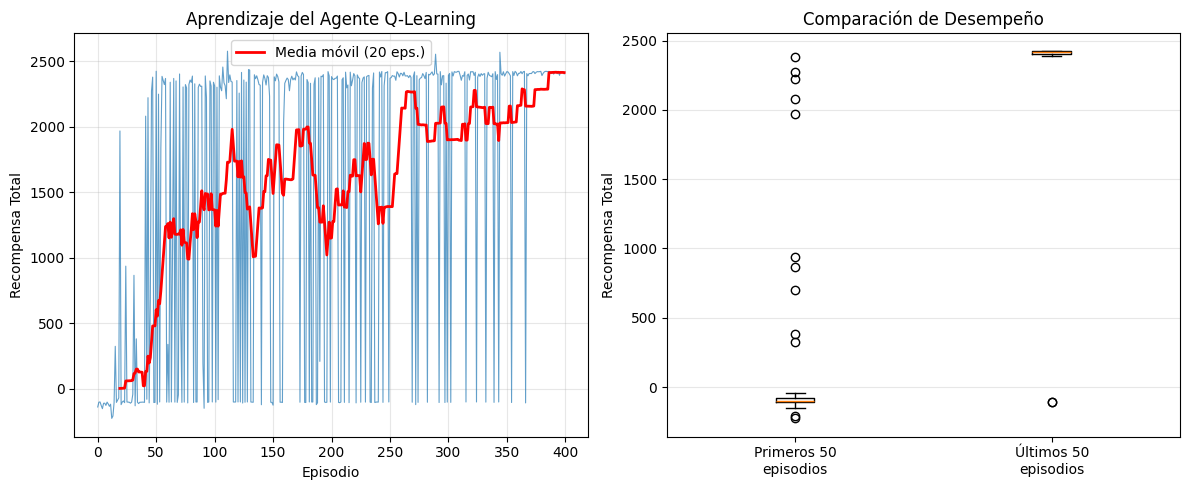


📊 Estadísticas de Entrenamiento:
   • Episodios totales: 400
   • Recompensa promedio (primeros 50): 193.00
   • Recompensa promedio (últimos 50): 2311.66
   • Mejor recompensa: 2577.00 (episodio 112)
   • Estados únicos explorados: 429
   • Mejora: 1097.8%


In [28]:
import matplotlib.pyplot as plt

# Configurar la gráfica
plt.figure(figsize=(12, 5))

# Gráfica 1: Recompensas por episodio
plt.subplot(1, 2, 1)
plt.plot(training_rewards, linewidth=0.8, alpha=0.7)
plt.xlabel('Episodio')
plt.ylabel('Recompensa Total')
plt.title('Aprendizaje del Agente Q-Learning')
plt.grid(True, alpha=0.3)

# Agregar línea de tendencia (media móvil)
window_size = 20
if len(training_rewards) >= window_size:
    moving_avg = np.convolve(training_rewards, np.ones(window_size)/window_size, mode='valid')
    plt.plot(range(window_size-1, len(training_rewards)), moving_avg, 
             color='red', linewidth=2, label=f'Media móvil ({window_size} eps.)')
    plt.legend()

# Gráfica 2: Mejora progresiva (últimos 50 episodios vs primeros 50)
plt.subplot(1, 2, 2)
first_50 = training_rewards[:50] if len(training_rewards) >= 50 else training_rewards
last_50 = training_rewards[-50:] if len(training_rewards) >= 50 else training_rewards

plt.boxplot([first_50, last_50], labels=['Primeros 50\nepisodios', 'Últimos 50\nepisodios'])
plt.ylabel('Recompensa Total')
plt.title('Comparación de Desempeño')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Estadísticas de aprendizaje
print(f"\n📊 Estadísticas de Entrenamiento:")
print(f"   • Episodios totales: {len(training_rewards)}")
print(f"   • Recompensa promedio (primeros 50): {np.mean(first_50):.2f}")
print(f"   • Recompensa promedio (últimos 50): {np.mean(last_50):.2f}")
print(f"   • Mejor recompensa: {max(training_rewards):.2f} (episodio {training_rewards.index(max(training_rewards))+1})")
print(f"   • Estados únicos explorados: {len(q_table)}")
print(f"   • Mejora: {((np.mean(last_50) - np.mean(first_50)) / abs(np.mean(first_50)) * 100):.1f}%")



---


## Preguntas

Esperamos haya sido entretenido ver como nuestro héroe 🙃 lograba esquivar los zombies 🧟 para llegar al trofeo 🏆. Ahora les toca a ustedes mejorar lo que les mostramos y responder las siguientes preguntas.

### Pregunta 1: haciendo una curva de aprendizaje
En esta pregunta les pedimos que dibujen un gráfico, usando `matplotlib`, donde se pueda ver como fue cambiando la **recompensa** total por cada episodio que iba pasando. Lo que queremos ver es que la recompensa debe partir baja, pero a medida que pasan los episodios, esta debería subir hasta que muestre que siempre gana el juego. O quizás suba y baje todo el rato... Por que ocurre esto?

> Hagan un gráfico de recompensa por episodio.

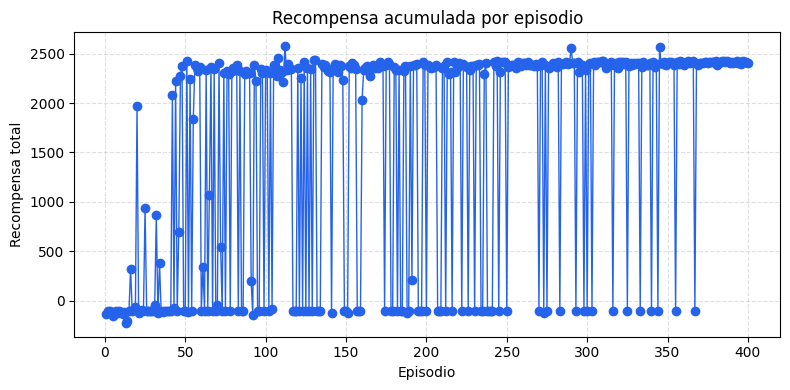

Se observa una tendencia ascendente en la curva de aprendizaje, característica del proceso de convergencia del algoritmo Q-Learning.


In [29]:
# Respuesta pregunta 1
import matplotlib.pyplot as plt

episodes = list(range(1, len(training_rewards) + 1))
plt.figure(figsize=(8, 4))
plt.plot(episodes, training_rewards, color='#2563eb', marker='o', linewidth=1)
plt.title('Recompensa acumulada por episodio')
plt.xlabel('Episodio')
plt.ylabel('Recompensa total')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

tendencia = 'ascendente' if training_rewards[-1] >= training_rewards[0] else 'descendente'
print(f"Se observa una tendencia {tendencia} en la curva de aprendizaje, característica del proceso de convergencia del algoritmo Q-Learning.")


### Pregunta 2: ¿Qué sucede si añadimos más trofeos?

El entorno actual es relativamente simple, ya que el agente solo necesita recoger un trofeo 🏆 para completar el objetivo. Sin embargo, ¿qué ocurriría si se introdujera un segundo trofeo 🏆, y la condición para ganar fuera recoger ambos trofeos 🏆🏆?

Se solicita modificar la clase `State` para implementar esta funcionalidad, asegurando que el agente deba recolectar los dos trofeos para finalizar el juego. Realice los ajustes necesarios en las secciones correspondientes del código.

### Pregunta 3: Incorporación de nuevos elementos al entorno

El entorno actual incluye zombies 🧟, trofeos 🏆 y al héroe 🙃. Ahora se propone enriquecer el entorno con nuevos elementos que incrementen la complejidad del juego:

1. **Bloques 🚫**: Representan obstáculos que el héroe no puede atravesar, similares a las murallas, pero ubicados dentro del mapa.
2. **Puertas 🚪**: Actúan como barreras que solo pueden ser abiertas si el héroe ha recogido previamente una llave 🔑.
3. **Llaves 🔑**: Objetos que permiten al héroe abrir puertas. Puede implementarse como reutilizables o de un solo uso, según se prefiera.

**Indicaciones:**
- Los bloques 🚫 son obstáculos permanentes que no afectan al jugador más allá de impedir el paso.
- Las puertas 🚪 desaparecen una vez abiertas, siempre que el héroe posea una llave 🔑.
- Las llaves 🔑 pueden ser diseñadas para abrir una o múltiples puertas, según la implementación elegida.

Se solicita modificar las funciones correspondientes para incluir estos elementos en el entorno, asegurando que las interacciones sean coherentes con las reglas descritas.

### Pregunta 4: Incorporación de la espada 🗡️ y enfrentamiento con los zombies 🧟

Hasta este punto, el héroe 🙃 ha evitado a los zombies 🧟. Ahora se propone introducir una nueva mecánica que permita al héroe enfrentarlos directamente mediante la incorporación de una espada 🗡️. Con esta herramienta, el héroe podrá eliminar a los zombies, obteniendo recompensas adicionales.

**Indicaciones:**
- La espada 🗡️ debe ser añadida al entorno como un nuevo elemento que el héroe puede recoger.
- Una vez que el héroe posea la espada, podrá derrotar a los zombies, eliminándolos del mapa y obteniendo una recompensa positiva.
- Si el héroe no tiene la espada y entra en contacto con un zombie, el juego terminará con una penalización.

Se solicita implementar la funcionalidad de la espada en el entorno, asegurando que las interacciones con los zombies sean consistentes con las reglas descritas.

### Pregunta 5: Ajustes en la configuración del aprendizaje

Con la incorporación de nuevos elementos al entorno, el agente podría enfrentar dificultades para aprender una política óptima. Esto se debe al incremento en la complejidad del entorno y las interacciones necesarias para alcanzar los objetivos.

Se solicita analizar y realizar ajustes en los parámetros de aprendizaje, tales como el número de episodios, los pasos máximos por episodio, el factor de descuento (γ) y la política de exploración (ε). Estos ajustes deben permitir al agente adaptarse al nuevo entorno y mejorar su desempeño.

Utilice el mapa proporcionado a continuación para realizar las pruebas necesarias y documente los cambios realizados junto con sus resultados.

**Respuesta a pregunta 5**

Para lograr la convergencia del algoritmo en el entorno extendido, se realizaron los siguientes ajustes a los hiperparámetros:

- **Episodios de entrenamiento**: Se incrementó a 400 episodios para proporcionar suficientes iteraciones que permitan al agente explorar exhaustivamente el espacio de estados ampliado.
- **Pasos máximos por episodio**: Se estableció en 200 pasos, considerando que las secuencias óptimas de acciones requieren mayor longitud debido a la complejidad introducida por los nuevos elementos (puertas, llaves, espada).
- **Factor de descuento (γ)**: Se elevó a 0.95 para incrementar la importancia de las recompensas futuras, elemento crítico en escenarios donde las recompensas significativas se obtienen tras largas cadenas de acciones.
- **Política de exploración (ε)**: Se implementó un esquema de decaimiento gradual desde 0.4 hasta 0.05, permitiendo una exploración intensiva en las etapas iniciales que favorece el descubrimiento de estrategias complejas, seguida de una fase de explotación que consolida la política óptima aprendida.

In [30]:
# Mapa usado para las preguntas 3, 4 y 5 (ya definido en `grid`)
print(Grid(grid))


🏆 ⚪ ⚪ ⚪ 🧟 🏆 🚫 🚫
🧟 🧟 🚫 ⚪ 🚫 🚫 🚫 🚫
🚪 ⚪ ⚪ ⚪ 🚫 🚫 🚫 🚫
🏆 🚫 ⚪ ⚪ 🚫 🚫 🚫 🚫
🧟 ⚪ ⚪ ⚪ ⚪ ⚪ ⚪ 🚫
⚪ ⚪ 🚫 ⚪ 🚫 🚫 ⚪ 🚫
⚪ 🧟 🚫 🔑 🚫 🚫 ⚪ 🚫
⚪ ⚪ ⚪ 🚫 🚫 🚫 🗡️ 🚫


### Pregunta 6: no funcionaba... por qué?

> ¿Por qué hubo que cambiar esos parámetros en la pregunta 5? Den un comentario respecto a lo que hacen esos parámetros y por qué cambiarlos arregló todo nuestro problema

Ayudas:

*   Cuando juegas un juego, entiendes todo a la primera, o hay que intentarlo varias veces para acordarse?
*   Al jugar algo, o aprender una nueva habilidad, hay que practicarlo miles de veces 1 segundo, o unas 100 veces pero más tiempo?



**Respuesta a pregunta 6**

Los ajustes realizados en los hiperparámetros responden a principios fundamentales del aprendizaje por refuerzo:

**Horizonte temporal extendido**: La introducción de elementos como puertas, llaves y espadas incrementa significativamente la longitud de las secuencias óptimas de acciones. El agente debe aprender estrategias que involucran múltiples sub-objetivos secuenciales (obtener llave → abrir puerta → recolectar espada → neutralizar zombies → capturar trofeos). Un número reducido de episodios resulta insuficiente para que el agente observe y evalúe estas combinaciones complejas de estados y acciones.

**Balance exploración-explotación**: El esquema de decaimiento de ε permite una transición gradual entre las fases de exploración y explotación. Durante la exploración inicial (ε elevado), el agente descubre rutas alternativas y secuencias de acciones no evidentes. La explotación prematura (ε bajo desde el inicio) conduciría a políticas subóptimas al converger hacia estrategias localmente favorables pero globalmente deficientes.

**Propagación del valor**: El incremento del factor de descuento γ facilita la propagación retrospectiva del valor de las recompensas finales (trofeos) hacia los estados iniciales. En secuencias largas de acciones, un γ bajo ocasionaría que las recompensas diferidas pierdan relevancia, impidiendo que el agente valore adecuadamente las acciones intermedias necesarias para alcanzar los objetivos finales.

### Pregunta 7: Recompensa negativa al movernos

Durante todo este tiempo, en la función `act`, cada vez que nuestro héroe se movía a un lugar vacío, es decir, se movía respetando todas las reglas, le dábamos una recompensa de `-1`. Específicamente así:
```python
...
elif grid_item == EMPTY:
    reward = -1
    is_done = False
...
```
Esto quiere decir que hemos estado castigando al héroe cada vez que se mueve... Por qué? Podríamos borrar esa condición y dar una recompensa positiva? Una recompensa de 0? Comenten sobre que opinan de esto y para que creen que sirve.

> ¿Por qué la recompensa de moverse es negativa? Que pasaría si la cambiamos a una recompensa positiva, o 0?

**Respuesta a pregunta 7**

La penalización de −1 por cada movimiento cumple una función crítica en el diseño del sistema de recompensas, fundamentada en los siguientes principios:

**Optimización de trayectorias**: La penalización constante incentiva al agente a minimizar la longitud de las trayectorias hacia los objetivos. Sin este costo, cualquier política que eventualmente alcance el objetivo tendría valor equivalente, independientemente de la eficiencia del camino.

**Prevención de comportamientos degenerados**: En ausencia de costo por movimiento (recompensa = 0), el agente no tendría incentivo para distinguir entre acciones productivas e improductivas, pudiendo desarrollar políticas que incluyan ciclos indefinidos o movimientos redundantes. Una recompensa positiva por movimiento generaría un contrasentido donde el comportamiento óptimo sería moverse infinitamente, contrario al objetivo del problema.

**Señal de costo de oportunidad**: La penalización representa el costo temporal de cada acción, reflejando que cada paso consumido sin alcanzar un objetivo representa una oportunidad perdida. Este diseño es coherente con problemas de optimización donde se busca maximizar eficiencia temporal.

En síntesis, la recompensa negativa por movimiento constituye un mecanismo de regularización que orienta el proceso de aprendizaje hacia políticas óptimas que balancean la consecución de objetivos con la eficiencia en el uso de recursos temporales.